### ***6. 시각화 전략***
**1. 시군구별 요리주점 밀도 지도 (Choropleth Map)**
- **목적**
    지역별 경쟁 강도(요리주점 밀도)의 공간적 분포를 직관적으로 파악
- **사용 변수**
    - 시군구별 요리주점 수
    - 시군구 면적 또는 인구 대비 점포 수
    - 밀도 지수 (표준화 값 권장)
- **시각화 방식**
    - 시군구 단위 Choropleth Map
    - 색상 단계: Low → High density
- **기대 해석**
    - 수도권/광역시 중심 고밀도 클러스터 존재 여부 확인
    - 금별맥주 다점포 지역과 고밀도 지역의 중첩 여부 확인
    - 경쟁 압력과 입점 전략의 공간적 관계 파악

**2. 요리주점 밀도 그룹별 성과 지표 박스플롯**
- **목적**
    - 경쟁 강도 수준에 따른 온라인 성과 차이 검증
- **집단 구분**
    - 저밀도 (하위 33%)
    - 중밀도 (중위 33%)
    - 고밀도 (상위 33%)
- **성과 변수**
    - log_방문자_리뷰수
    - 월평균_리뷰수_log
    - 평점
- **시각화 방식**
    - x축: 밀도 그룹
    - y축: 성과 지표
    - Boxplot + 평균점 표시
- **기대 해석**
    - 고밀도 지역에서 리뷰 수 감소 여부
    - 경쟁 심화에 따른 성과 분산 증가 여부
    - 밀도와 성과 간 비선형 관계 탐색

**3. 자사 vs 경쟁사 입지 변수 분포 KDE**
- **목적**
    - 금별맥주와 경쟁사(예: 역전할머니맥주)의 입지 전략 차이 확인
- **비교 변수**
    - 요리주점 밀도
    - 인구밀도
    - 상권등급
    - 유동인구 (가능 시)
- **시각화 방식**
    - KDE Plot (Kernel Density Estimation)
    - 동일 축 위에 두 브랜드 곡선 중첩

- **기대 해석**
    - 특정 밀도 구간 집중 여부
    - 자사가 더 경쟁 강한 지역에 입점하는지 여부
    - 전략적 차별성 존재 여부

**4. 리뷰 수 대비 평점 산점도**
- (평점 안정성 확인 목적)
- **목적**
    - 리뷰 수가 증가함에 따라 평점이 안정되는지 확인
    → 평점 신뢰도 및 변동성 검증

- **사용 변수**
    - x축: log_방문자_리뷰수
    - y축: 평점
    - 점 크기: 월평균 리뷰 수 (선택)
- **추가 요소**
    - 회귀선 또는 LOWESS 곡선
    - 95% 신뢰구간 표시

- **기대 해석**
    - 리뷰 수 적은 점포
    → 평점 분산 큼 (극단값 존재 가능)

    - 리뷰 수 많은 점포
    → 평점 수렴(안정화)

    - 브랜드 간 비교 시
    → 한 브랜드가 더 안정적 평점 구조 보유 여부 확인 가능

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 자사/경쟁사 파일
path1 = r"C:\Users\user\Desktop\260219_데이터분석\분석용\merge_자사경쟁사.csv"
df1 = pd.read_csv(path1)

# 2. 입지 변수 파일
path2 = r"C:\Users\user\Desktop\260219_데이터분석\분석용\Step2_입지변수_결합완료.csv"
df2 = pd.read_csv(path2)

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

print("df1:", df1.shape)
print("df2:", df2.shape)

df1: (430, 6)
df2: (430, 45)


In [96]:
# 2. 타입 통일 후 병합
# ----------------------------
df1['place_id'] = df1['place_id'].astype(str)
df2['place_id'] = df2['place_id'].astype(str)

df = df2.merge(
    df1[['place_id','월평균_리뷰수_log','brand_type','요리주점_존재']],
    on='place_id',
    how='left'
)

print("merge 후:", df.shape)

merge 후: (430, 48)


In [97]:
# 3. 결측 확인
# ----------------------------
print("요리주점_밀도 결측:", df['요리주점_밀도'].isna().sum())
print("월평균_리뷰수_log 결측:", df['월평균_리뷰수_log'].isna().sum())

요리주점_밀도 결측: 127
월평균_리뷰수_log 결측: 0


In [98]:
# 4. 분석용 데이터 생성
# ----------------------------
df = df.dropna(subset=['요리주점_밀도','월평균_리뷰수_log'])

print("결측 제거 후:", df.shape)
print(df['brand_type'].value_counts())

df['시군구명'] = df['시군구명'].str.strip()

결측 제거 후: (303, 48)
brand_type
경쟁사    235
자사      68
Name: count, dtype: int64


### **시군구별 요리주점 밀도 비교**

In [100]:
# 요리주점 컬럼이 숫자형이 아닌 object(문자)형이라서 평균 계산이 안 되는 경우
# 1. 숫자형 변환
df['요리주점_밀도'] = pd.to_numeric(df['요리주점_밀도'], errors='coerce')

# 2. 결측값 제거
df = df.dropna(subset=['요리주점_밀도'])

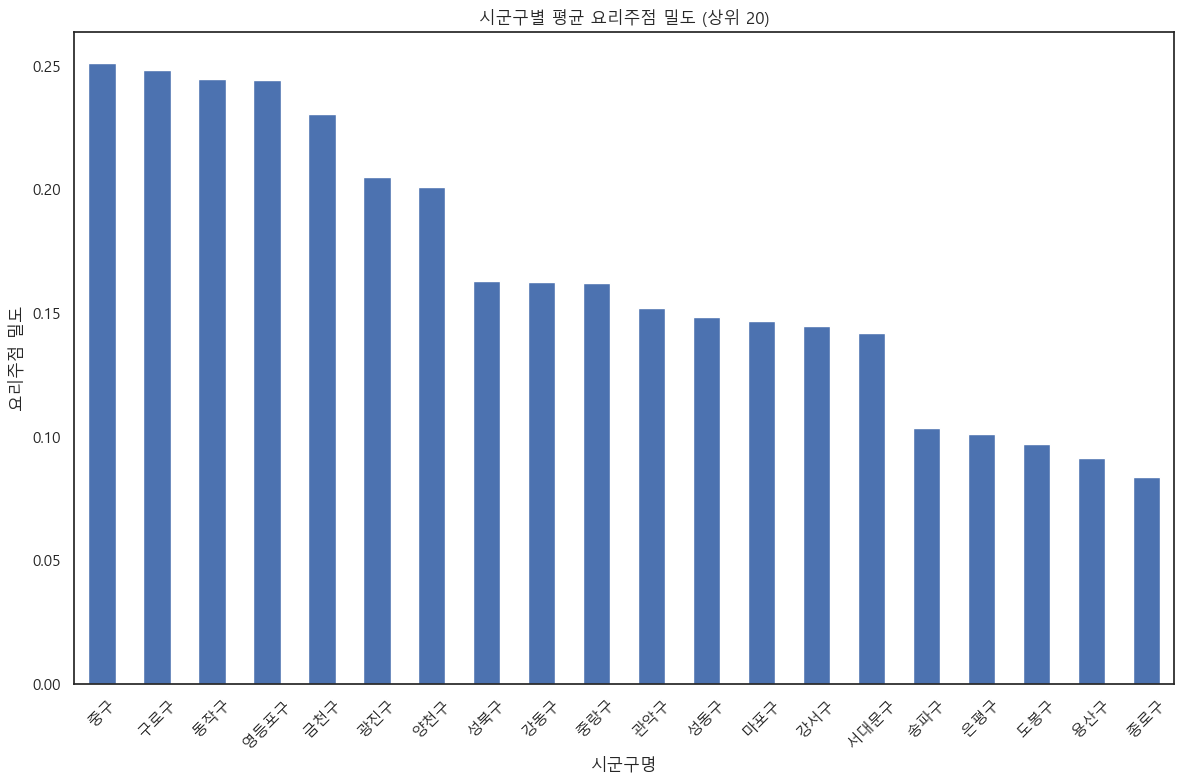

In [101]:
sgg_density = (
    df.groupby('시군구명')['요리주점_밀도']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,8))
sgg_density.head(20).plot(kind='bar')

plt.title("시군구별 평균 요리주점 밀도 (상위 20)")
plt.ylabel("요리주점 밀도")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_16156\1840368886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['밀도그룹'] = pd.qcut(


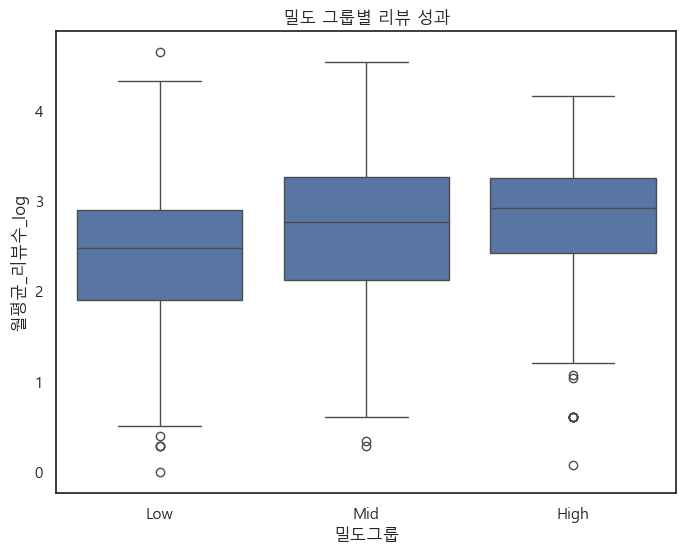

In [104]:
# 밀도 그룹별 성과지표 박스플롯
df['밀도그룹'] = pd.qcut(
    df['요리주점_밀도'],
    q=3,
    labels=['Low','Mid','High']
)

plt.figure(figsize=(8,6))

sns.boxplot(
    data=df,
    x='밀도그룹',
    y='월평균_리뷰수_log'
)

plt.title("밀도 그룹별 리뷰 성과")
plt.show()

### **해석**
1. X축: 밀도 그룹
    - Low : 요리주점 밀도가 낮은 시군구
    - Mid : 요리주점 밀도가 중간인 시군구
    - High : 요리주점 밀도가 높은 시군구

2. Y축: 월평균 리뷰 수 로그 (월평균_리뷰수_log)
    - 값이 높을수록 해당 시군구/점포의 월간 리뷰 반응이 높음을 의미
    - 로그 변환으로 극단치 영향을 완화

3. 박스플롯 의미
    - 박스: 25~75% 사분위 범위 (IQR)
    - 중앙선: 중앙값 (Median)
    - 점/선/아웃라이어: IQR 밖의 값

4. 해석 예시
    - Low 밀도 그룹의 중앙값이 Mid나 High보다 낮으면 → 요리주점 밀도가 낮은 곳은 월간 리뷰 반응도 낮음
    - High 그룹의 박스가 넓거나 상단에 아웃라이어가 많으면 → 밀도가 높아도 특정 점포는 리뷰 반응이 매우 높거나 낮을 수 있음
    - 그룹 간 중앙값 차이가 크면 → 요리주점 밀도가 월평균 리뷰 수에 어느 정도 영향을 준다고 해석 가능

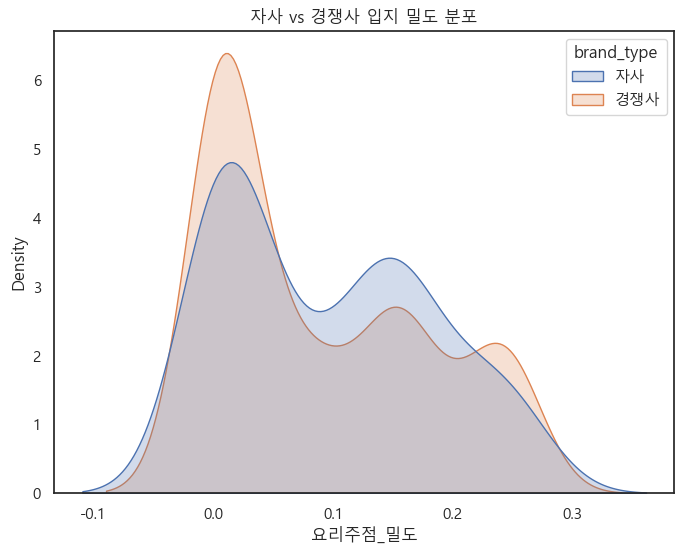

In [111]:
# 자사 vs 경쟁사 입지 분포 KDE
plt.figure(figsize=(8,6))

sns.kdeplot(
    data=df,
    x='요리주점_밀도',
    hue='brand_type',
    fill=True,
    common_norm=False
)

plt.title("자사 vs 경쟁사 입지 밀도 분포")
plt.show()

In [108]:
# 방문자_리뷰수 대비 월평균_리뷰수_log 산점도
# 필수 컬럼 확인 & 결측 제거

# 숫자형 변환
df['방문자_리뷰수'] = pd.to_numeric(df['방문자_리뷰수'], errors='coerce')
df['월평균_리뷰수_log'] = pd.to_numeric(df['월평균_리뷰수_log'], errors='coerce')

# 결측 제거
df = df.dropna(subset=['방문자_리뷰수', '월평균_리뷰수_log'])

C:\Users\user\AppData\Local\Temp\ipykernel_16156\1882070485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['방문자_리뷰수'] = pd.to_numeric(df['방문자_리뷰수'], errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_16156\1882070485.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['월평균_리뷰수_log'] = pd.to_numeric(df['월평균_리뷰수_log'], errors='coerce')


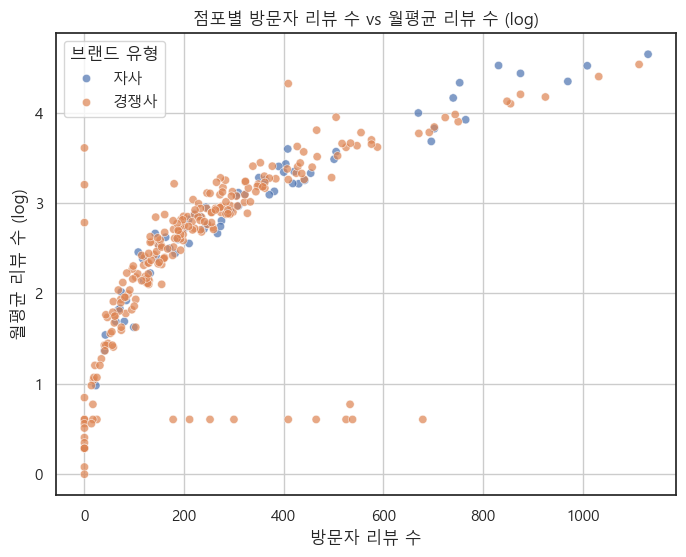

In [ ]:
# 4. 산점도 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='방문자_리뷰수',
    y='월평균_리뷰수_log',
    hue='brand_type',      # 자사/경쟁사 구분
    alpha=0.7
)
plt.xlabel("방문자 리뷰 수")
plt.ylabel("월평균 리뷰 수 (log)")
plt.title("점포별 방문자 리뷰 수 vs 월평균 리뷰 수 (log)")
plt.legend(title="브랜드 유형")
plt.grid(True)
plt.show()